# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [42]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*30     # 30 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [34]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [35]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [36]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der absoluten Lateness minimieren

$$
\min \sum_{j \in J} \left| C_j - d_j \right|
$$

- $J$: Menge aller Jobs  
- $C_j$: tatsächliche Endzeit (Completion Time) von Job $j$  
- $d_j$: Deadline von Job $j$  
- $\left| C_j - d_j \right|$: absolute Abweichung zur Deadline

**Erklärung:**  
Diese Zielfunktion minimiert die **Summe aller Abweichungen zur Deadline**, unabhängig davon, ob ein Job zu früh oder zu spät fertig wird.  
Sie fördert eine **gleichmäßige, zentrierte Fertigstellung** aller Jobs um ihre Soll-Zeitpunkte (Deadlines).

In [37]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Status           : OPTIMAL
Summe Absolute Lateness : 0.0
Best Objective Bound    : 0.0
Laufzeit                : 0.04 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


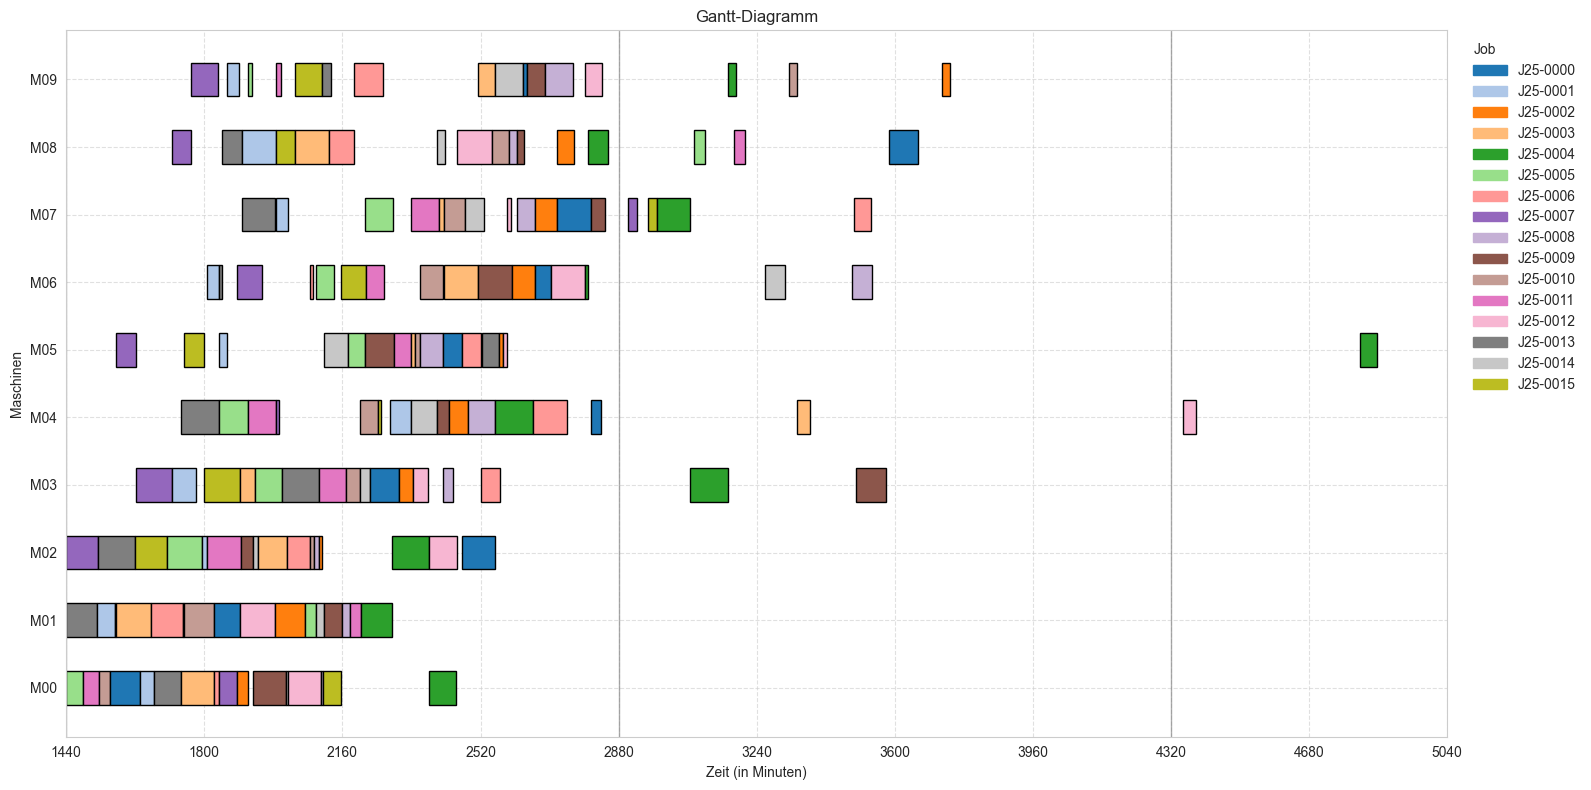

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [38]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [43]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:58:00] Job J25-0005 finished on M00 (after 58 minutes)
[Day 1 00:58:00] Job J25-0011 started on M00
[Day 1 01:08:00] Job J25-0013 finished on M01 (after 68 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:36:00] Job J25-0007 finished on M02 (after 96 minutes)
[Day 1 01:36:00] Job J25-0013 started on M02
[Day 1 01:37:00] Job J25-0011 finished on M00 (after 39 minutes)
[Day 1 01:37:00] Job J25-0010 started on M00
[Day 1 01:58:00] Job J25-0001 finished on M01 (after 37 minutes)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:09:00] Job J25-0010 finished on M00 (after 32 minutes)
[Day 1 02:09:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:09:00] Job J25-0000 started on M00
[Day 1 02:09:00] Job J25-0003 started on M01
[Day 1 02:09:00] Job J25-0007 started on M05
[Day 1 02:56:00] Job J25-0007 finished on M05 (aft

In [44]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,79,1569.0,71.0,1640.0
1,8,J25-0000,1,M01,79,1865.0,54.0,1919.0
2,8,J25-0000,2,M03,79,2263.0,71.0,2334.0
3,8,J25-0000,3,M05,79,2459.0,57.0,2516.0
4,8,J25-0000,4,M02,79,2516.0,95.0,2611.0
5,8,J25-0000,5,M09,79,2684.0,10.0,2694.0
...,...,...,...,...,...,...,...,...
133,5,J25-0015,3,M03,1436,1830.0,90.0,1920.0
134,5,J25-0015,4,M08,1436,1988.0,42.0,2030.0
135,5,J25-0015,5,M09,1436,2036.0,85.0,2121.0


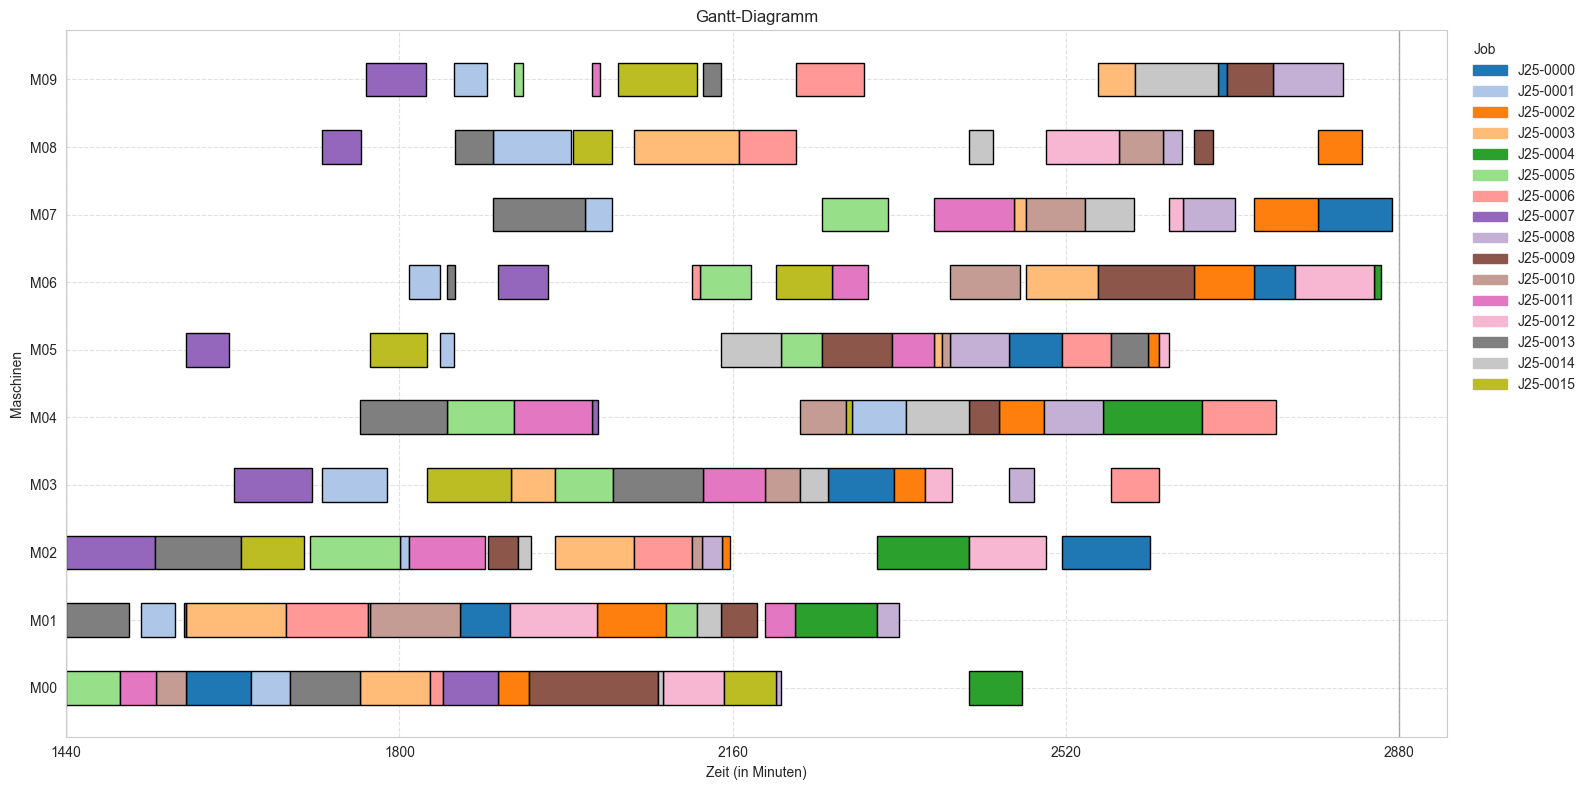

In [45]:
show.plot_gantt(df_execution, perspective="Machine")

In [46]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0000,8,M04,79,2872.0,26,28.0,2898.0,2900.0
1,J25-0004,5,M08,287,2861.0,52,58.0,2913.0,2919.0
2,J25-0009,8,M07,1004,2872.0,36,26.0,2908.0,2898.0
3,J25-0012,8,M09,1103,2853.0,45,66.0,2898.0,2919.0


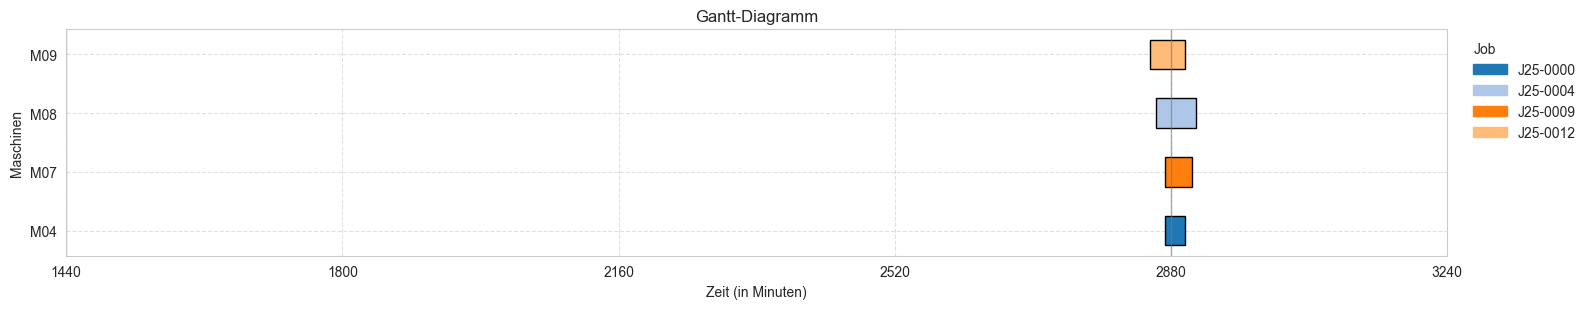

In [53]:
if df_active is not None:
    show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [54]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
1,J25-0002,0,198,1440,3744,9,M09,3723,21,3744
2,J25-0003,2,243,1440,3379,9,M04,3346,33,3379
3,J25-0004,3,287,1440,4856,6,M07,2981,85,3066
4,J25-0004,3,287,1440,4856,7,M03,3066,98,3164
5,J25-0004,3,287,1440,4856,8,M09,3164,22,3186
...,...,...,...,...,...,...,...,...,...,...
11,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
12,J25-0010,0,1025,1440,3345,9,M09,3324,21,3345
13,J25-0011,1,1030,1440,3210,9,M08,3180,30,3210


#### b) Summe der Lateness (gewichtete Tardiness und Earliness) minimieren

### Zielfunktion

$$
\min \sum_{j \in J} \left( w_t \cdot \max(C_j - d_j,\ 0) + w_e \cdot \max(d_j - C_j,\ 0) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Endzeit (Completion Time) des letzten Arbeitsschritts von Job $j$
- $d_j$: Deadline (Soll-Endzeitpunkt) von Job $j$
- $w_t$: Gewichtung der **Tardiness** (Verspätung)
- $w_e$: Gewichtung der **Earliness** (Frühfertigkeit)
- $\max(C_j - d_j,\ 0)$: positive Verspätung
- $\max(d_j - C_j,\ 0)$: positive Frühfertigkeit

### Erklärung

Diese Zielfunktion minimiert die gewichtete Summe aus **Tardiness** (Verspätung) und **Earliness** (Frühfertigkeit) aller Jobs.
Dabei wird jede Abweichung zur Deadline einzeln bewertet:

- **Tardiness** wird mit $w_t$ gewichtet und tritt auf, wenn ein Job **nach** seiner Deadline fertig wird.
- **Earliness** wird mit $w_e$ gewichtet und tritt auf, wenn ein Job **vor** seiner Deadline fertig wird.

Durch die Wahl von $w_t \gg w_e$ kannst du **Verspätungen deutlich stärker bestrafen** als Frühfertigkeiten.

In [55]:
# Scheduling
df_schedule_b = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time", w_t= 5,
    msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule_b


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.03 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0006,9,790,1440,3539,9,M07,3494,45,3539
155,J25-0009,7,1004,1440,3578,9,M03,3499,79,3578
156,J25-0000,8,79,1440,3660,9,M08,3586,74,3660


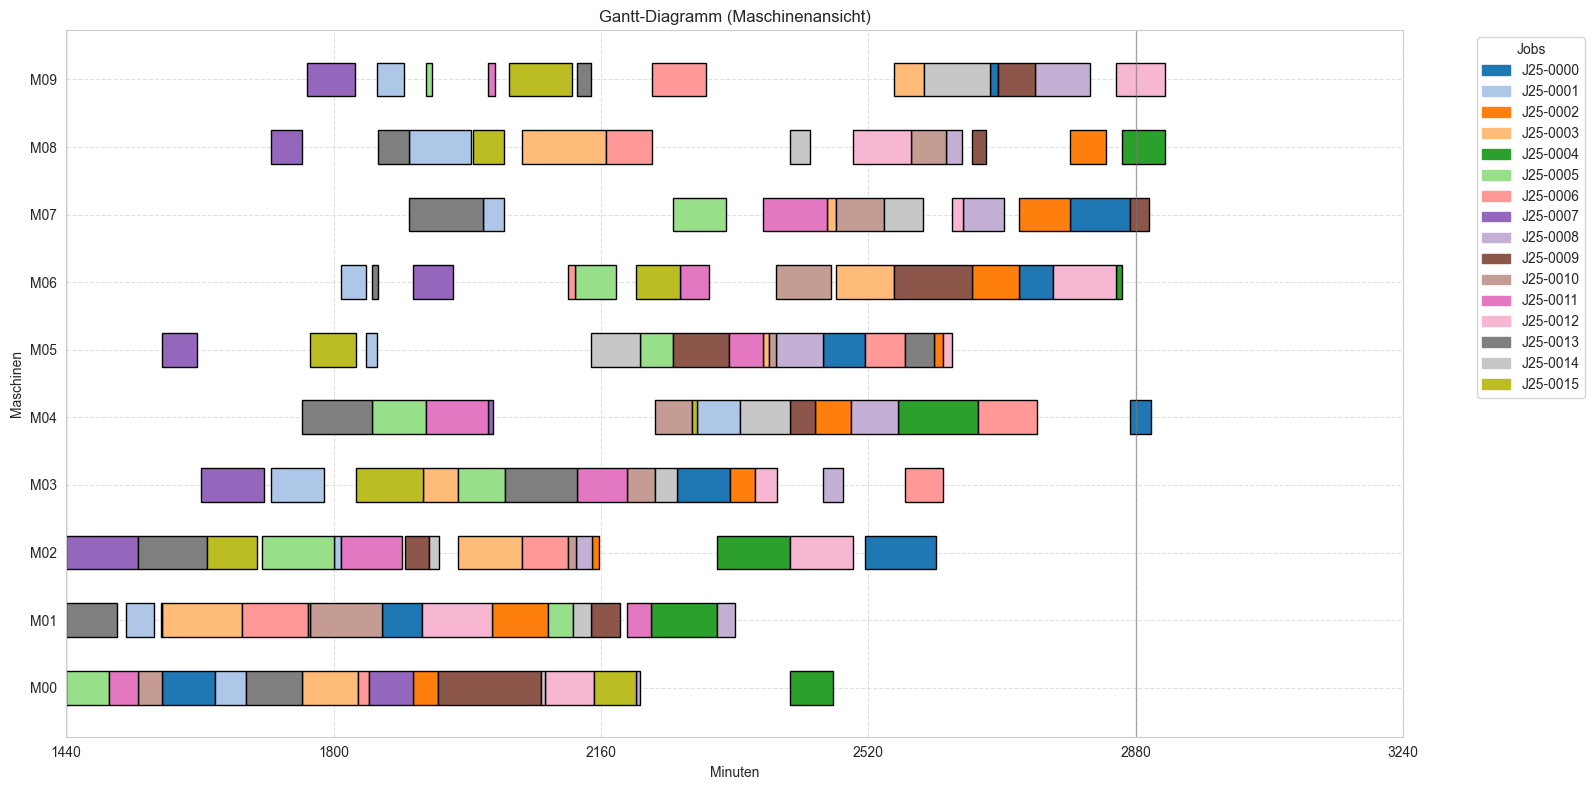

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [56]:
columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)

## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [57]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [58]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [21]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
29,J25-0002,0,9,M09,21
39,J25-0003,2,9,M04,33
46,J25-0004,3,6,M07,85
47,J25-0004,3,7,M03,98
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [22]:
df_schedule_simple = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, w_t = 5,
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple


Solver-Status         : OPTIMAL
Objective Value       : 710.00
Best Objective Bound  : 710.00
Laufzeit              : 0.21 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0017,7,1864,2880,4980,0,M02,2880,31,2911
1,J25-0028,0,2282,2880,5291,0,M00,2880,29,2909
2,J25-0018,8,1919,2880,4772,0,M00,2909,76,2985
3,J25-0028,0,2282,2880,5291,1,M01,2909,78,2987
4,J25-0027,7,2277,2880,5711,0,M02,2911,31,2942
5,J25-0029,4,2301,2880,4675,0,M02,2942,14,2956
...,...,...,...,...,...,...,...,...,...,...
232,J25-0028,0,2282,2880,5291,9,M09,5270,21,5291
233,J25-0021,5,1952,2880,5368,9,M07,5343,25,5368
234,J25-0027,7,2277,2880,5711,9,M03,5632,79,5711


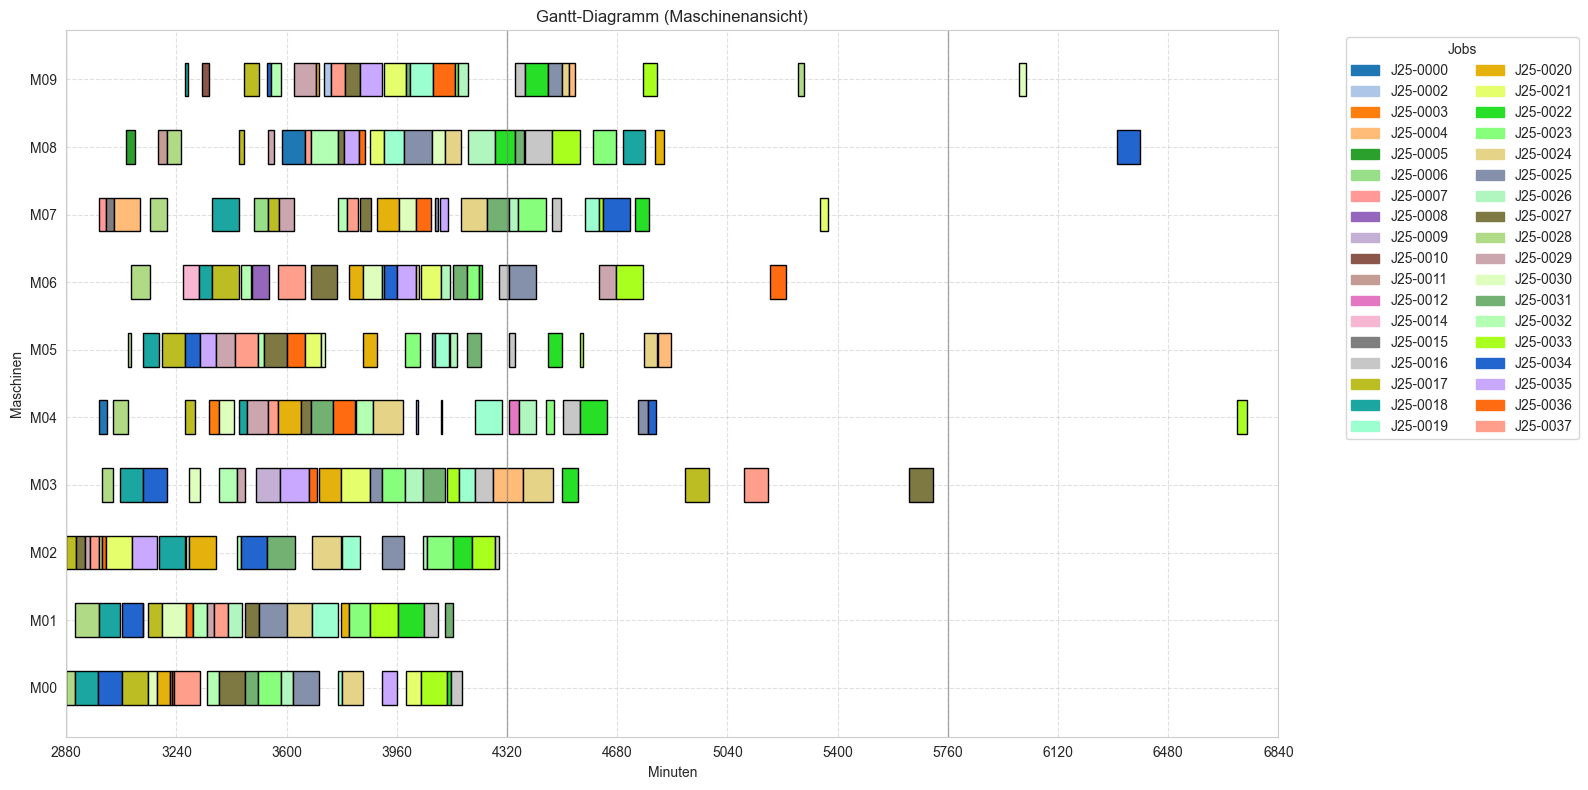

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

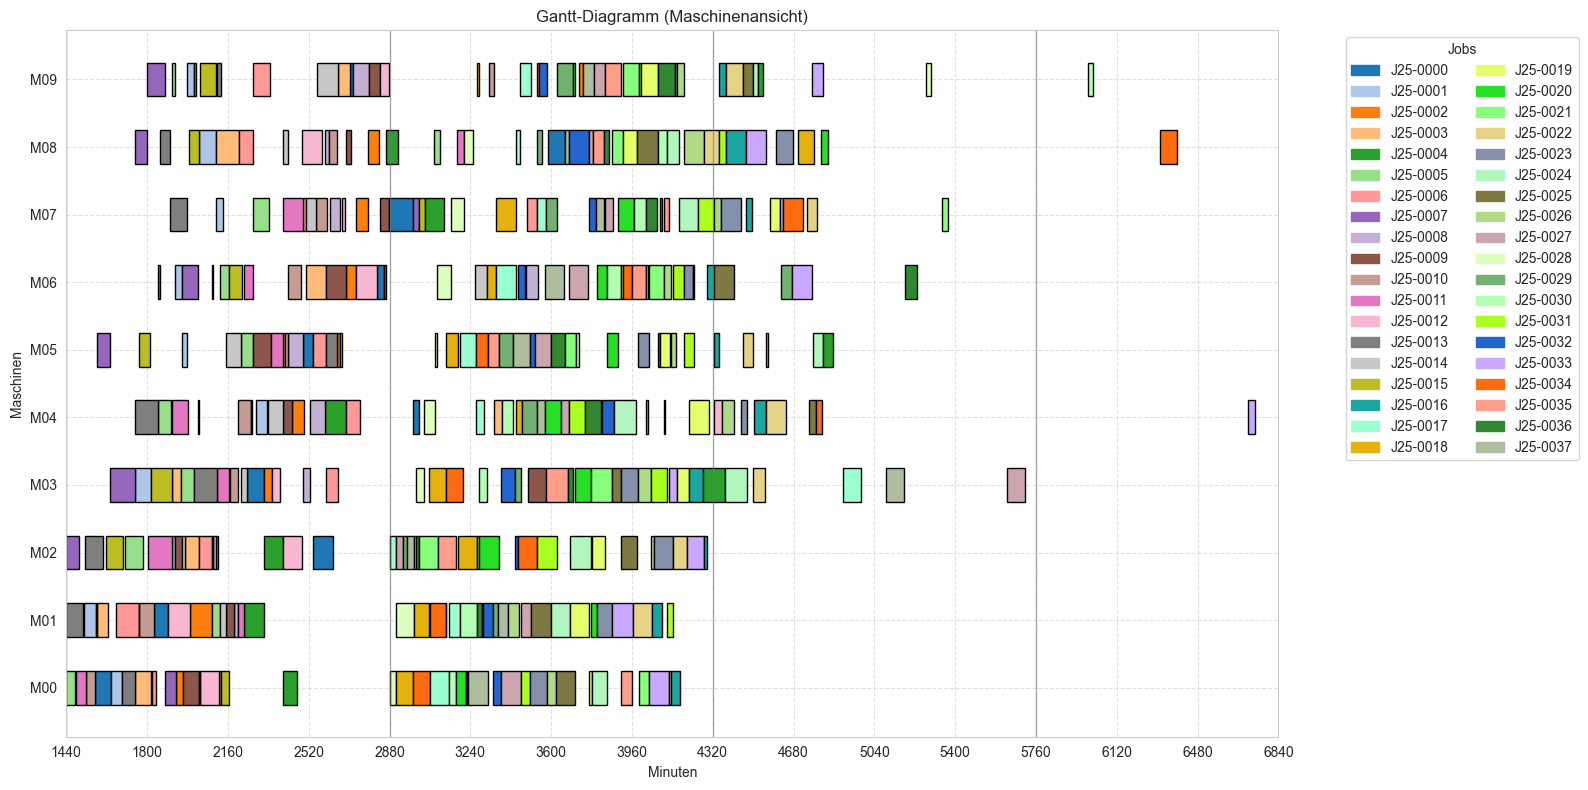

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [24]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [25]:
df_schedule_devpen = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    w_t = 5,
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start,
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen


Solver-Status         : OPTIMAL
Objective Value       : 62800.00
Best Objective Bound  : 62060.00
Laufzeit              : 0.25 Sekunden
Deviation terms       : 18


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0019,9,1925,2880,4621,0,M01,2880,85,2965
1,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0023,8,2055,2880,4676,0,M00,2923,76,2999
4,J25-0031,1,2567,2880,4377,1,M02,2964,90,3054
5,J25-0035,5,2726,2880,4126,1,M01,2965,2,2967
...,...,...,...,...,...,...,...,...,...,...
232,J25-0028,0,2282,2880,5291,9,M09,5270,21,5291
233,J25-0021,5,1952,2880,5368,9,M07,5343,25,5368
234,J25-0027,7,2277,2880,5711,9,M03,5632,79,5711


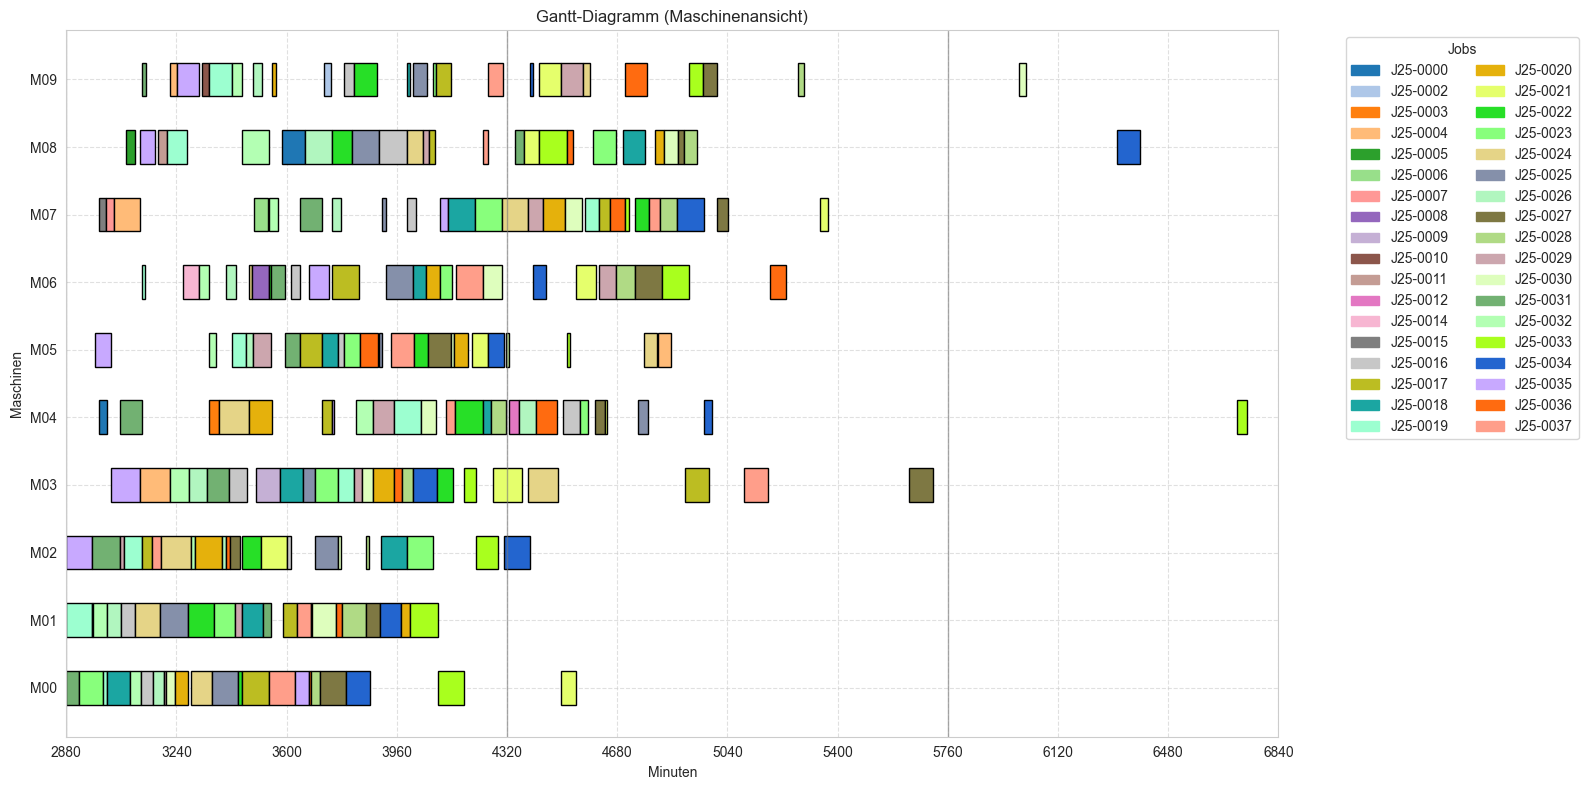

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

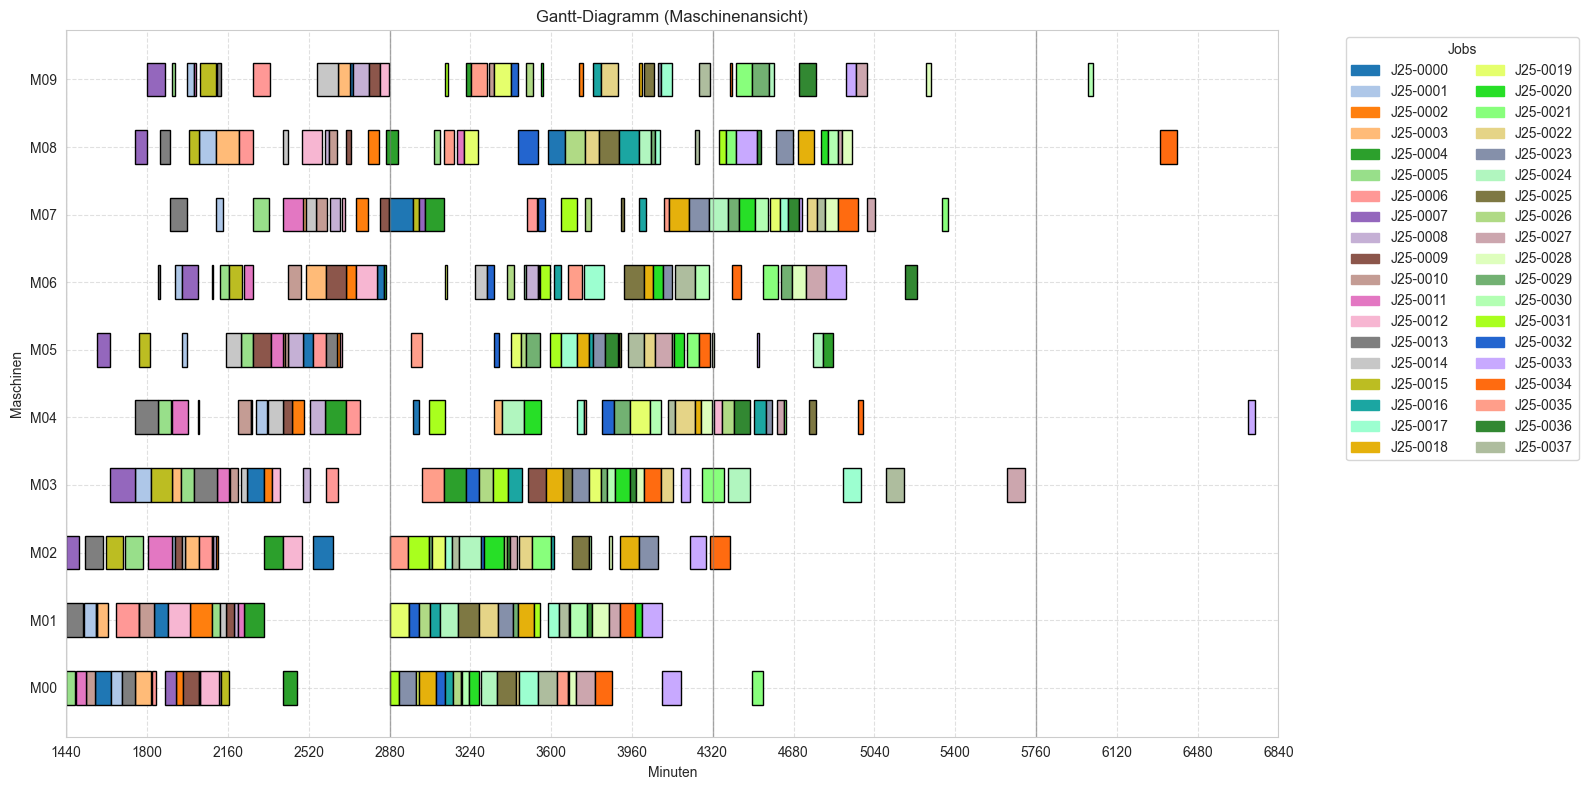

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [27]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [28]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0004, Operation 5 resumed with 36.00 min
[Day 2 00:00:00] Job J25-0000, Operation 7 resumed with 106.00 min
[Day 2 00:00:00] Job J25-0019 started on M01
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:36:00] Job J25-0004 finished on M08 (after 36 minutes)
[Day 2 00:51:00] Job J25-0031 finished on M00 (after 51 minutes)
[Day 2 00:51:00] Job J25-0023 started on M00
[Day 2 01:18:00] Job J25-0035 finished on M02 (after 78 minutes)
[Day 2 01:23:00] Job J25-0019 finished on M01 (after 83 minutes)
[Day 2 01:24:00] Job J25-0031 started on M02
[Day 2 01:25:00] Job J25-0035 started on M01
[Day 2 01:27:00] Job J25-0035 finished on M01 (after 02 minutes)
[Day 2 01:27:00] Job J25-0032 started on M01
[Day 2 01:34:00] Job J25-0035 started on M05
[Day 2 01:46:00] Job J25-0000 finished on M07 (after 106 minutes)
[Day 2 01:46:00] Job J25-0000 started on M04
[Day 2 01:46:00] Job J25-0015 started on M07
[Day 2 02:06:00] Job J25-0

In [29]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,7,M07,79,2876.0,110.0,2986.0,NaN
1,J25-0000,8,M04,79,2986.0,20.0,3006.0,8.0
2,J25-0000,9,M08,79,3586.0,76.0,3662.0,8.0
3,J25-0002,9,M09,198,3723.0,19.0,3742.0,0.0
4,J25-0003,9,M04,243,3346.0,32.0,3378.0,2.0
5,J25-0004,5,M08,287,2865.0,51.0,2916.0,NaN
...,...,...,...,...,...,...,...,...
167,J25-0037,1,M00,2801,3575.0,105.0,3680.0,7.0
168,J25-0037,2,M01,2801,3682.0,47.0,3729.0,7.0
169,J25-0037,3,M05,2801,3942.0,71.0,4013.0,7.0


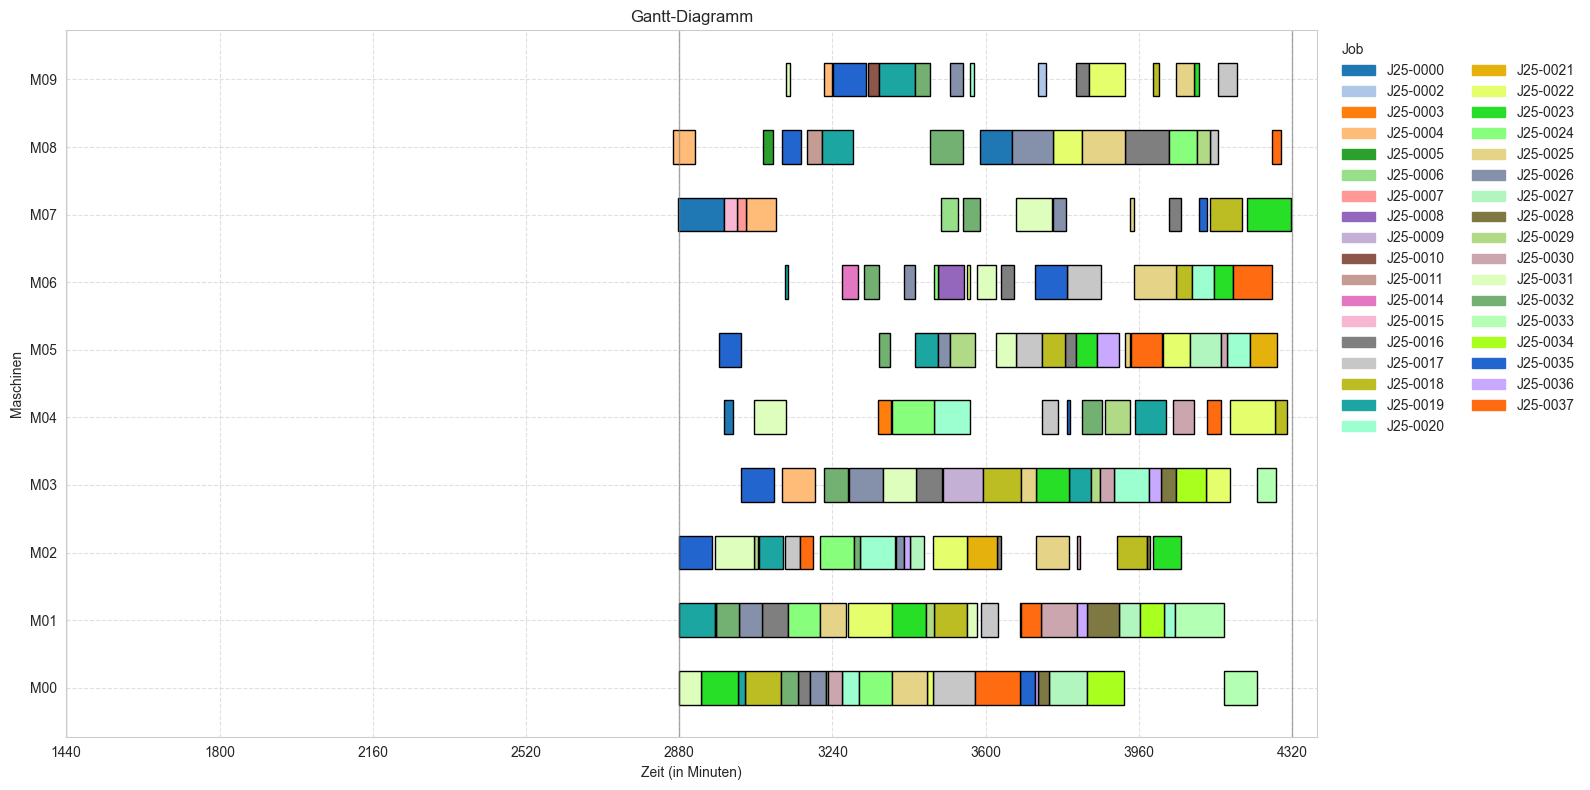

In [30]:
show.plot_gantt(df_execution2, perspective="Machine")

In [31]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0021,3,M03,1952,4284.0,95,72.0,4379.0,4356.0
1,J25-0024,6,M07,2108,4318.0,85,101.0,4403.0,4419.0
2,J25-0028,4,M04,2282,4307.0,49,49.0,4356.0,4356.0
3,J25-0030,6,M06,2313,4272.0,62,48.0,4334.0,4320.0
4,J25-0033,3,M02,2660,4282.0,74,60.0,4356.0,4342.0
5,J25-0034,3,M05,2715,4284.0,51,47.0,4335.0,4331.0
6,J25-0037,7,M09,2801,4293.0,48,46.0,4341.0,4339.0


In [32]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,0,M00,1555,76,1631
1,J25-0000,8,79,1440,3660,1,M01,1825,69,1894
2,J25-0000,8,79,1440,3660,2,M03,2231,76,2307
3,J25-0000,8,79,1440,3660,3,M05,2422,51,2473
4,J25-0000,8,79,1440,3660,4,M02,2473,85,2558
5,J25-0000,8,79,1440,3660,5,M09,2630,11,2641
...,...,...,...,...,...,...,...,...,...,...
136,J25-0015,5,1436,1440,2981,3,M03,1799,95,1894
137,J25-0015,5,1436,1440,2981,4,M08,1988,48,2036
138,J25-0015,5,1436,1440,2981,5,M09,2036,72,2108


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

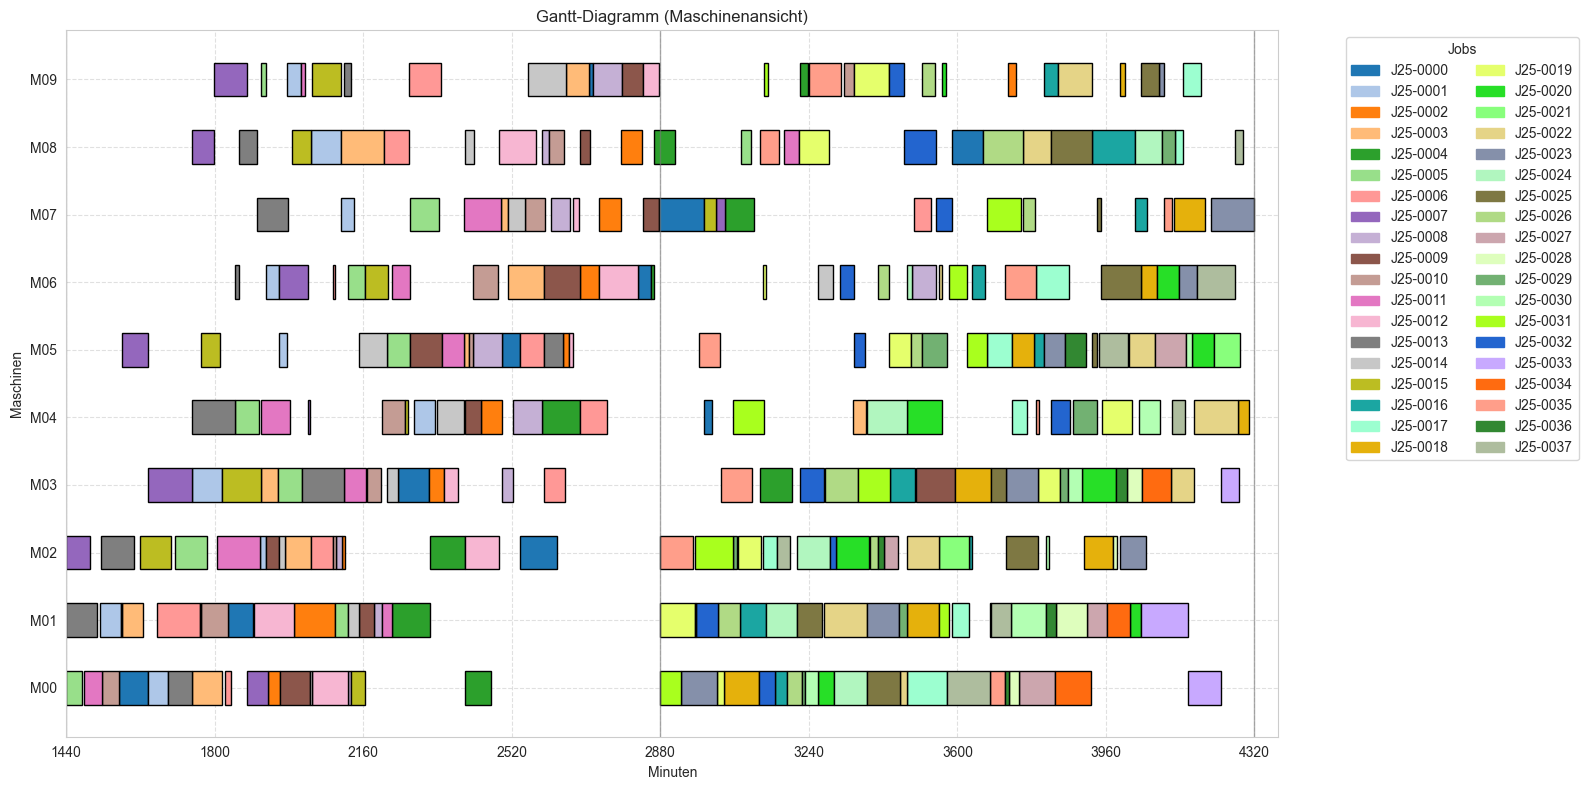

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [33]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)